In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from kalman_reconstruction.pipeline import from_standard_dataset
from kalman_reconstruction.custom_plot import set_custom_rcParams
from reconstruct_climate_indices.statistics import linear_regression_loglog
from pathlib import Path
import yaml

In [2]:
REPO_PATH = Path(".").resolve().parent
REPO_PATH

WindowsPath('C:/Users/Niebaum/Documents/Repositories/reconstruct-climate-indices')

In [3]:
## LIGHT THEME
plt.style.use("seaborn-v0_8-whitegrid")
dark_color = [0.3, 0.3, 0.3]
light_color = [0.8, 0.8, 0.8]
lightness_0 = 0.75
lightness_1 = 0.5
cmap = "rocket"
cmap_r = "rocket_r"

# ### DARK THEME
# plt.style.use("dark_background")
# dark_color = [0.7, 0.7, 0.7]
# light_color = [0.2, 0.2, 0.2]
# lightness_0 = 1.15
# lightness_1 = 1.5
# cmap = "rocket_r"
# cmap_r = "rocket"


colors = set_custom_rcParams()
# plt.rcParams["axes.grid"] = False

# plot_colors(colors)

variables_color = dict()
variables_color["SAT"] = colors[0]
variables_color["SST"] = colors[2]
variables_color["DOT"] = colors[1]
variables_color["latent"] = colors[3]
variables_color["loglikelihood"] = (colors[-1],)

In [234]:
REPO_PATH = Path(".").resolve().parent
results_path = REPO_PATH / Path("results") / "Report" / "appendix"
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

In [235]:
df = 0.115
tau0 = 10 # years
per0 = 24  # years
lambda0 = 2 / tau0 #/ (2 * np.pi) # years
omega0 = 2 * np.pi/per0 # / (2 * np.pi)# years 
# NOTE: 
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5} 
SAT_factor = np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$" 
SST_DOT_PSD_units = r"$K^2 y^{-1}$" 

print(rf"$\lambda_0$ = {lambda0}")
print(rf"$\omega_0$ = {omega0}")

$\lambda_0$ = 0.2
$\omega_0$ = 0.2617993877991494


## 1000 y

In [236]:
welch_windon_width = 300

### Oscillatory

In [237]:
SubdataPath = "simplified_ocean_experiments"
oscillatory_run_name = "carefree-crow-386" 

# SubdataPath = "Evaluation-Idealized-Ocean"
# oscillatory_run_name = "fun-ape-341"

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    # seed = 26437479881
    # seed=331381460666,
)
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillator_data = experiments.sel(select_dict)
oscillator_kalman_states = experiments_kalman_states.sel(select_dict)
# oscillator_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )
from scipy import signal
fs = 12
frequencies, SAT_spectrum = signal.welch(
        x=oscillator_data["SAT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, SST_spectrum = signal.welch(
        x=oscillator_data["SST"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, DOT_spectrum = signal.welch(
        x=oscillator_data["DOT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, latent_spectrum = signal.welch(
        x=oscillator_kalman_states["latent"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )

# create linear regression in loglog space
frequencies_linear, spectrum_linear, regression = linear_regression_loglog(
    frequencies=frequencies,
    spectrum=latent_spectrum,
    weights=None,
    f_low=omega0,
    f_high=10**(0) 
)
slope = regression.coef_[0, 0]
# tau0 = 10
# lambda0 = 2/ tau0 
# per0 = 1
# omega0 = 2 * np.pi / per0

### Sponge Ocean

In [238]:
SubdataPath = "simplified_ocean_experiments"
sponge_run_name = "omniscient-panda-587" 

# SubdataPath = "Evaluation-Idealized-Ocean"
# oscillatory_run_name = "fun-ape-341"

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

# Oscillatory ocean
run_name = sponge_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = sponge_select_dict


sponge_data = experiments.sel(select_dict)
sponge_kalman_states = experiments_kalman_states.sel(select_dict)
# oscillator_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )
from scipy import signal
fs = 12
frequencies, SAT_spectrum_sponge = signal.welch(
        x=sponge_data["SAT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, SST_spectrum_sponge = signal.welch(
        x=sponge_data["SST"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )

In [239]:
# print((SAT_spectrum.mean()))
# print((0.115**2/(2*np.pi)))

0.2 0.2617993877991494


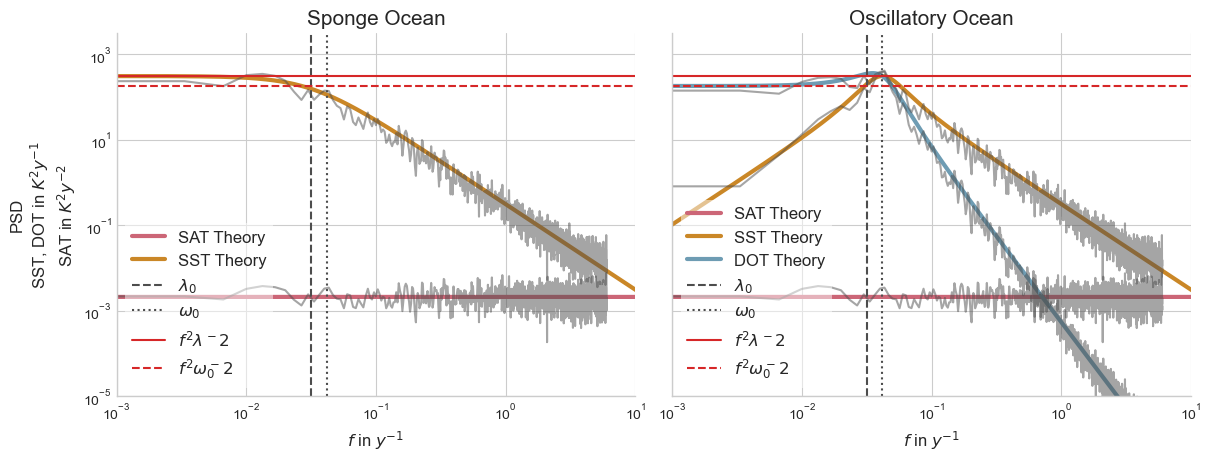

In [243]:
print(lambda0, omega0)

omega = np.logspace(-4,2, 12000)


# THEORY
f = 0.115 / (2 * np.pi)
SAT_PSD = omega * 0 + f**2 * 2 * np.pi
f = f * 2 * np.pi * 365.25/12

SST_PSD = (omega**2 * f**2) / (omega**2 * lambda0**2 + ((omega**2 - omega0**2)**2))
DOT_PSD = (omega0**2/(omega**2)) * SST_PSD

SST_PSD_sponge = f**2 / (omega**2 + lambda0**2)


fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (8*1.5,4.5), layout="constrained")

# THEORY:
# axs_SAT = axs.copy()
# for i in range(len(axs)):
#     axs_SAT[i] = axs[i].twinx()

# Oscilatory
axs[1].loglog(omega/ (2*np.pi), SAT_PSD, color = variables_color["SAT"], label = "SAT Theory", linewidth = 3)
axs[1].loglog(omega/ (2*np.pi), SST_PSD, color = variables_color["SST"], label = "SST Theory", linewidth = 3)
axs[1].loglog(omega/ (2*np.pi), DOT_PSD, color = variables_color["DOT"], label = "DOT Theory", linewidth = 3)

# Sponge
axs[0].loglog(omega/ (2*np.pi), SAT_PSD, color = variables_color["SAT"], label = "SAT Theory", linewidth = 3)
axs[0].loglog(omega/ (2*np.pi), SST_PSD_sponge, color = variables_color["SST"], label = "SST Theory", linewidth = 3)


# NUMERICAL
axs[1].plot(frequencies, DOT_spectrum, color = dark_color, alpha = 0.5)
axs[1].plot(frequencies, SST_spectrum, color = dark_color, alpha = 0.5)
axs[1].plot(frequencies, SAT_spectrum, color = dark_color, alpha = 0.5)

axs[0].plot(frequencies, SST_spectrum_sponge, color = dark_color, alpha = 0.5)
axs[0].plot(frequencies, SAT_spectrum_sponge, color = dark_color, alpha = 0.5)

# THEORY CONSTANTS
for ax in axs: 
    ax.axvline(lambda0 / (2*np.pi), color = dark_color, linestyle = "--", label = f"$\lambda_0$")
    ax.axvline(omega0 / (2*np.pi), color = dark_color, linestyle = ":", label = f"$\omega_0$")
    ax.axhline(f**2/lambda0**2, color = "tab:red", label = f"$f^{2}\lambda^{-2}$")
    ax.axhline(f**2/omega0**2, color = "tab:red", linestyle = "--", label = f"$f^{2}\omega_0^{-2}$")

# for ax, ax_SAT in zip(axs, axs_SAT):
#     # ask matplotlib for the plotted objects and their labels
#     lines, labels = ax.get_legend_handles_labels()
#     lines_SAT, labels_SAT = ax_SAT.get_legend_handles_labels()
for ax in axs :
    ax.legend(loc="lower left")
    ax.set_ylim(10 ** (-5), 10 **(3.5))
    ax.set_xlim(10 ** (-3), 10 **(1))
    ax.set_xlabel(r"$f$ in $y^{-1}$")
axs[0].set_ylabel(f"PSD\nSST, DOT in {SST_DOT_PSD_units}\nSAT in {SAT_PSD_units}")
axs[0].set_title("Sponge Ocean")
axs[1].set_title("Oscillatory Ocean")

save_fig(fig, relative_path=f"1000y_theoretical_example_tau0_{tau0}_per0_{per0}.pdf")

0.1 0.5235987755982988


Text(0.5, 0, '$f$ in $y^{-1}$')

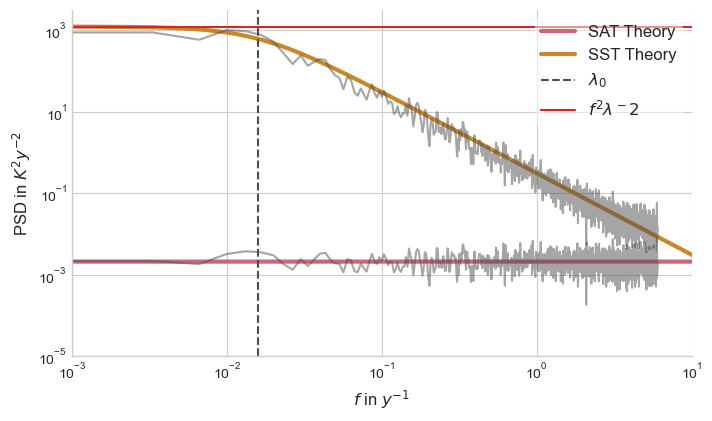

In [190]:
print(lambda0, omega0)

omega = np.logspace(-4,2, 12000)

# THEORY
f = 0.115 / (2 * np.pi)
SAT_PSD = omega * 0 + f**2 * 2 * np.pi
f = f * 2 * np.pi * 365.25/12


SST_PSD = f**2 / (omega**2 + lambda0**2)
plt.loglog(omega/ (2*np.pi), SAT_PSD, color = variables_color["SAT"], label = "SAT Theory", linewidth = 3)
plt.loglog(omega/ (2*np.pi), SST_PSD, color = variables_color["SST"], label = "SST Theory", linewidth = 3)

# THEORY CONSTANTS
plt.axvline(lambda0  / (2*np.pi), color = dark_color, linestyle = "--", label = f"$\lambda_0$")
plt.axhline(f**2/lambda0**2, color = "tab:red", label = f"$f^{2}\lambda^{-2}$")

# NUMERICAL
plt.loglog(frequencies, SAT_spectrum_sponge, color = dark_color, alpha = 0.5)
plt.loglog(frequencies, SST_spectrum_sponge, color = dark_color, alpha = 0.5)

plt.legend()
plt.ylim(10 ** (-5), 10 **(3.5))
plt.xlim(10 ** (-3), 10 **(1))
plt.ylabel(r"PSD in $K^2 y^{-2}$")
plt.xlabel(r"$f$ in $y^{-1}$")


## 150 y

In [184]:
iseed = 0

0.015915494309189534 0.020833333333333332


Text(0.5, 0, '$f$ in $y^{-1}$')

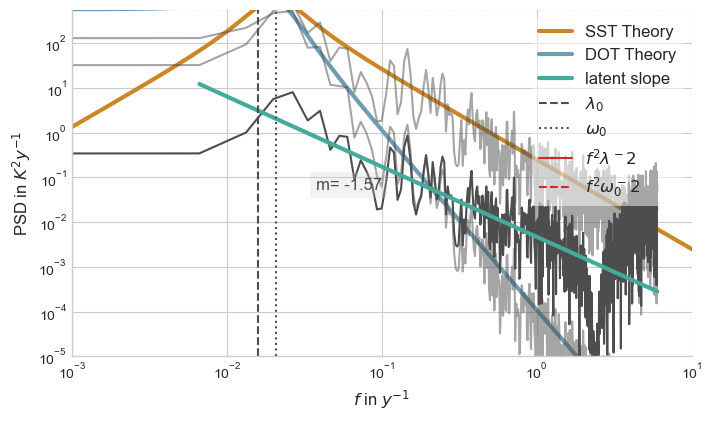

In [185]:
# SubdataPath = "simplified_ocean_experiments"
# oscillatory_run_name = "carefree-crow-386" 

SubdataPath = "Evaluation-Idealized-Ocean"
oscillatory_run_name = "fun-ape-341"

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    # seed=331381460666,
)
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillator_data = experiments.sel(select_dict).isel(seed = iseed)
oscillator_kalman_states = experiments_kalman_states.sel(select_dict).isel(seed = iseed)
# oscillator_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )
from scipy import signal
fs = 12
frequencies, SAT_spectrum = signal.welch(
        x=oscillator_data["SAT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, SST_spectrum = signal.welch(
        x=oscillator_data["SST"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, DOT_spectrum = signal.welch(
        x=oscillator_data["DOT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, latent_spectrum = signal.welch(
        x=oscillator_kalman_states["latent"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )

# create linear regression in loglog space
frequencies_linear, spectrum_linear, regression = linear_regression_loglog(
    frequencies=frequencies,
    spectrum=latent_spectrum,
    weights=None,
    f_low=omega0,
    f_high=10**(0) 
)
slope = regression.coef_[0, 0]
# tau0 = 10
# lambda0 = 2/ tau0 
# per0 = 1
# omega0 = 2 * np.pi / per0

print(lambda0, omega0)
f = S0 = 10 ** (-0.3)

omega = np.logspace(-4,2, 1000)


# THEORY
SST_PSD = (omega**2 * f**2) / (omega**2 * lambda0**2 + ((omega**2 - omega0**2)**2))
DOT_PSD = (omega0**2/(omega**2)) * SST_PSD
plt.loglog(omega, SST_PSD, color = variables_color["SST"], label = "SST Theory", linewidth = 3)
plt.loglog(omega, DOT_PSD, color = variables_color["DOT"], label = "DOT Theory", linewidth = 3)


# NUMERICAL
plt.plot(frequencies, DOT_spectrum, color = dark_color, alpha = 0.5)
plt.plot(frequencies, SST_spectrum, color = dark_color, alpha = 0.5)
plt.plot(frequencies, latent_spectrum, color = dark_color, label = None,) #variables_color["latent"], )
plt.loglog(
    frequencies_linear,
    spectrum_linear,
    color=variables_color["latent"],
    linewidth = 3,
    label = "latent slope"
)


# THEORY CONSTANTS
plt.axvline(lambda0, color = dark_color, linestyle = "--", label = f"$\lambda_0$")
plt.axvline(omega0, color = dark_color, linestyle = ":", label = f"$\omega_0$")
plt.axhline(f**2/lambda0**2, color = "tab:red", label = f"$f^{2}\lambda^{-2}$")
plt.axhline(f**2/omega0**2, color = "tab:red", linestyle = "--", label = f"$f^{2}\omega_0^{-2}$")


plt.text(
    10**(-1),
    10**(-1),
    f"m= {slope:.2f}",
    ha="right",
    va="top",
    bbox=dict(facecolor=light_color, edgecolor="None", alpha=0.25),
    color=dark_color,
) 

plt.legend()
plt.ylim(10 ** (-5), 10 **(2.75))
plt.xlim(10 ** (-3), 10 **(1))
plt.ylabel(r"PSD in $K^2 y^{-1}$")
plt.xlabel(r"$f$ in $y^{-1}$")


In [189]:
iseed = 2

In [190]:
# SubdataPath = "simplified_ocean_experiments"
# oscillatory_run_name = "carefree-crow-386" 

SubdataPath = "Evaluation-Idealized-Ocean"
oscillatory_run_name = "fun-ape-341"

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    # seed=331381460666,
)
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillator_data = experiments.sel(select_dict).isel(seed = iseed)
oscillator_kalman_states = experiments_kalman_states.sel(select_dict).isel(seed = iseed)
# oscillator_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )

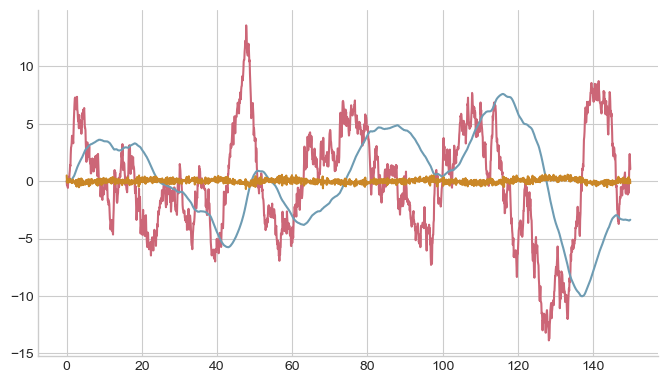

In [191]:
plt.plot(oscillator_data.time_years, oscillator_data["SST"])
plt.plot(oscillator_data.time_years, oscillator_data["DOT"])
plt.plot(oscillator_kalman_states.time_years, oscillator_kalman_states["latent"])

In [ ]:

from scipy import signal
fs = 12
frequencies, SAT_spectrum = signal.welch(
        x=oscillator_data["SAT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, SST_spectrum = signal.welch(
        x=oscillator_data["SST"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, DOT_spectrum = signal.welch(
        x=oscillator_data["DOT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, latent_spectrum = signal.welch(
        x=oscillator_kalman_states["latent"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )

# create linear regression in loglog space
frequencies_linear, spectrum_linear, regression = linear_regression_loglog(
    frequencies=frequencies,
    spectrum=latent_spectrum,
    weights=None,
    f_low=omega0,
    f_high=10**(0) 
)
slope = regression.coef_[0, 0]
# tau0 = 10
# lambda0 = 2/ tau0 
# per0 = 1
# omega0 = 2 * np.pi / per0

print(lambda0, omega0)
f = S0 = 10 ** (-0.3)

omega = np.logspace(-4,2, 1000)


# THEORY
SST_PSD = (omega**2 * f**2) / (omega**2 * lambda0**2 + ((omega**2 - omega0**2)**2))
DOT_PSD = (omega0**2/(omega**2)) * SST_PSD
plt.loglog(omega, SST_PSD, color = variables_color["SST"], label = "SST Theory", linewidth = 3)
plt.loglog(omega, DOT_PSD, color = variables_color["DOT"], label = "DOT Theory", linewidth = 3)


# NUMERICAL
plt.plot(frequencies, DOT_spectrum, color = dark_color, alpha = 0.5)
plt.plot(frequencies, SST_spectrum, color = dark_color, alpha = 0.5)
plt.plot(frequencies, latent_spectrum, color = dark_color, label = None,) #variables_color["latent"], )
plt.loglog(
    frequencies_linear,
    spectrum_linear,
    color=variables_color["latent"],
    linewidth = 3,
    label = "latent slope"
)


# THEORY CONSTANTS
plt.axvline(lambda0, color = dark_color, linestyle = "--", label = f"$\lambda_0$")
plt.axvline(omega0, color = dark_color, linestyle = ":", label = f"$\omega_0$")
plt.axhline(f**2/lambda0**2, color = "tab:red", label = f"$f^{2}\lambda^{-2}$")
plt.axhline(f**2/omega0**2, color = "tab:red", linestyle = "--", label = f"$f^{2}\omega_0^{-2}$")


plt.text(
    10**(-1),
    10**(-1),
    f"m= {slope:.2f}",
    ha="right",
    va="top",
    bbox=dict(facecolor=light_color, edgecolor="None", alpha=0.25),
    color=dark_color,
) 

plt.legend()
plt.ylim(10 ** (-5), 10 **(2.75))
plt.xlim(10 ** (-3), 10 **(1))
plt.ylabel(r"PSD in $K^2 y^{-1}$")
plt.xlabel(r"$f$ in $y^{-1}$")


## SPonge Ocean

In [97]:
SubdataPath = "simplified_ocean_experiments"
sponge_run_name = "omniscient-panda-587" 

# SubdataPath = "Evaluation-Idealized-Ocean"
# oscillatory_run_name = "fun-ape-341"

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # df=df,
)

# Oscillatory ocean
run_name = sponge_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    settings = yaml.safe_load(stream)
select_dict = sponge_select_dict


sponge_data = experiments.sel(select_dict)
sponge_kalman_states = experiments_kalman_states.sel(select_dict)
# oscillator_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )
from scipy import signal
fs = 12
frequencies, SAT_spectrum_sponge = signal.welch(
        x=sponge_data["SAT"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )
frequencies, SST_spectrum_sponge = signal.welch(
        x=sponge_data["SST"], 
        fs=fs, 
        window="hann", 
        nperseg=int(welch_windon_width* fs),
    )

0.1 0.5235987755982988


Text(0.5, 0, '$f$ in $y^{-1}$')

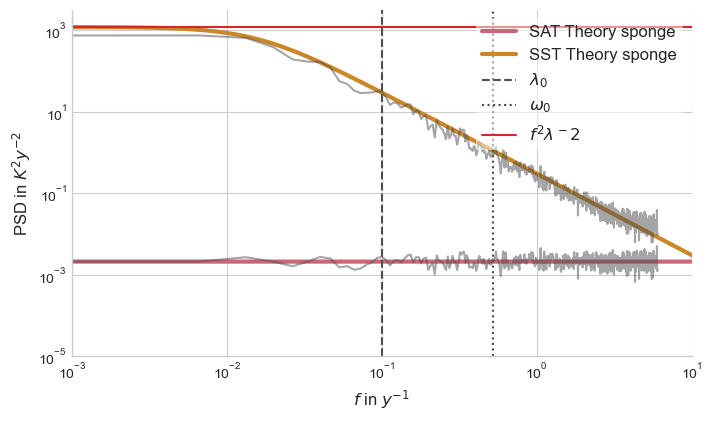

In [141]:
print(lambda0, omega0)

omega = np.logspace(-4,2, 12000)

# THEORY
f = np.sqrt((0.115**2) / (2 * np.pi))
SAT_PSD = omega * 0 + f**2
f = f * 2 * np.pi * 12 
SST_PSD = f**2 / (omega**2 + lambda0**2)
plt.loglog(omega/ (2*np.pi), SAT_PSD, color = variables_color["SAT"], label = "SAT Theory sponge", linewidth = 3)
plt.loglog(omega/ (2*np.pi), SST_PSD, color = variables_color["SST"], label = "SST Theory sponge", linewidth = 3)

# THEORY CONSTANTS
plt.axvline(lambda0, color = dark_color, linestyle = "--", label = f"$\lambda_0$")
plt.axvline(omega0, color = dark_color, linestyle = ":", label = f"$\omega_0$")
plt.axhline(f**2/lambda0**2, color = "tab:red", label = f"$f^{2}\lambda^{-2}$")

# NUMERICAL
plt.loglog(frequencies, SAT_spectrum_sponge, color = dark_color, alpha = 0.5)
plt.loglog(frequencies, SST_spectrum_sponge, color = dark_color, alpha = 0.5)

plt.legend()
plt.ylim(10 ** (-5), 10 **(3.5))
plt.xlim(10 ** (-3), 10 **(1))
plt.ylabel(r"PSD in $K^2 y^{-2}$")
plt.xlabel(r"$f$ in $y^{-1}$")


In [127]:
(12 * 2 * np.pi)**2

5684.89213502747